# Applications of Regression

## Overview

In this lab you will apply regression to some realistic data. In this lab you will work with the automotive price dataset. Your goal is to construct a linear regression model to predict the price of automobiles from their characteristics. 

In this lab will learn to:

1. Use categorical data with Scikit-Learn. 
2. Apply transformations to features and labels to improve model performance. 
3. Compare regression models to improve model performance. 

## Load the dataset

As a first, step you will load the dataset into the notebook environment. 

First, execute the code in the cell below to load  the packages you will need to run the rest of this notebook. 

In [2]:
import pandas as pd
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math

%matplotlib inline

The code in the cell below loads the dataset and performs several data cleanup steps. Execute this code and ensure that the expected columns are present. 

In [3]:
auto_prices = pd.read_csv('Automobile price data _Raw_.csv')

def clean_auto_data(auto_prices):
    'Function to load the auto price data set from a .csv file' 
    import pandas as pd
    import numpy as np
    
    ## Remove rows with missing values, accounting for mising values coded as '?'
    cols = ['price', 'bore', 'stroke', 
          'horsepower', 'peak-rpm']
    for column in cols:
        auto_prices.loc[auto_prices[column] == '?', column] = np.nan
    auto_prices.dropna(axis = 0, inplace = True)

    ## Convert some columns to numeric values
    for column in cols:
        auto_prices[column] = pd.to_numeric(auto_prices[column])
    
    ## fix column names so the '-' character becomes '_'
    cols = auto_prices.columns
    auto_prices.columns = [str.replace('-', '_') for str in cols]
        
    return auto_prices
auto_prices = clean_auto_data(auto_prices)

print(auto_prices.columns)

Index(['symboling', 'normalized_losses', 'make', 'fuel_type', 'aspiration',
       'num_of_doors', 'body_style', 'drive_wheels', 'engine_location',
       'wheel_base', 'length', 'width', 'height', 'curb_weight', 'engine_type',
       'num_of_cylinders', 'engine_size', 'fuel_system', 'bore', 'stroke',
       'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg',
       'highway_mpg', 'price'],
      dtype='object')


As a next step, execute the code in the cell below to display and examine the first few rows of the dataset. 

In [4]:
auto_prices.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


Notice that there are both numeric and categorical features. 

## Transform some variables

Before building any machine learning model data transformations should be applied. Generally, deterimining which transformations to apply is performed by careful exploration of the data set. Failure to perform these steps generally results in machine learning models with suboptimal performance. 

### Agregating categorical variables

When a dataset contains categorical variables these need to be investigated to ensure that each category has sufficient samples. It is commonly the case that some categories may have very few samples, or have so many similar categories as to be meaningless. 

As a specific case, you will examine the number of cylinders in the cars. Execute the cell below to print a frequency table for this variable and examine the result. 

In [5]:
auto_prices[['fuel_type', 'num_of_cylinders']].groupby('num_of_cylinders').count()

,fuel_type
num_of_cylinders,
eight,4
five,10
four,155
six,24
three,1
twelve,1


Notice that there is only one car with three and twelve cylinders. There are only four cars with eight cylinders, and 10 cars with five cylinders. It is likely that all of these categories will not have statistically significant difference in predicting auto price. It is clear that these categories need to be aggregated. 

The code in the cell below uses a Python dictionary to recode the number of cylinder categories into a smaller number categories. Execute this code and examine the resulting frequency table.

In [6]:
cylinder_categories = {'three':'three_four', 'four':'three_four', 
                    'five':'five_six', 'six':'five_six',
                    'eight':'eight_twelve', 'twelve':'eight_twelve'}
auto_prices['num_of_cylinders'] = [cylinder_categories[x] for x in auto_prices['num_of_cylinders']]
auto_prices[['fuel_type', 'num_of_cylinders']].groupby('num_of_cylinders').count()

,fuel_type
num_of_cylinders,
eight_twelve,5
five_six,34
three_four,156


There are now three categories. One of these categories only has five members. However, it is likely that these autos will have different pricing from others. 

Now, execute the code in the cell below and examine the frequency table for the `body_style` feature.

In [7]:
auto_prices[['fuel_type', 'body_style']].groupby('body_style').count()

,fuel_type
body_style,
convertible,6
hardtop,8
hatchback,63
sedan,94
wagon,24


Two of these categories have a limited number of members, but for now this feature will not be agregated. This can be done later to improve model performance. 

### Transforming numeric variables

To improve performance of machine learning models transformations of the values are often applied. Typically, transformations are used to make the relationships betweeen variables more linear. In other cases, transformations are performed to make distributions closer to Normal, or at least more symmetric. These transformations can include taking logarithms, exponential transformations and power transformations. 

In this case, you will transform the label, the price of the car. Execute the code in the cell below to display and examine a histogram of the label. 

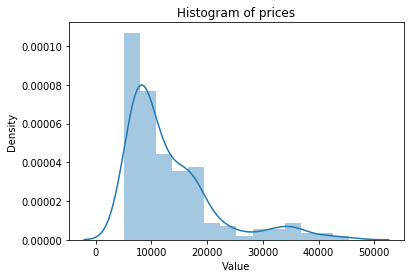

In [8]:
def hist_plot(vals, lab):
    ## Distribution plot of values
    sns.distplot(vals)
    plt.title('Histogram of ' + lab)
    plt.xlabel('Value')
    plt.ylabel('Density')
    
labels = np.array(auto_prices['price'])
hist_plot(labels, 'prices')

The distribution of auto price is both quite skewed to the left and multimodal. Given the skew and the fact that there are no values less than or equal to zero, a log transformation might be appropriate.

The code in the cell below displays a histogram of the logarithm of prices. Execute this code and examine the result. 

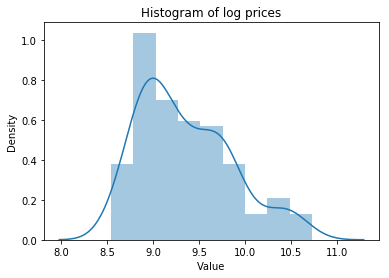

In [9]:
labels = np.log(labels)
hist_plot(labels, 'log prices')

The distribution of the logarithm of price is more symmetric, but still shows some multimodal tendancy and skew. None the less, this is an improvement so we will use these values as our label.

Execute the code in the cell below add the logarithmic transformation of the label to the dataset. 

In [10]:
auto_prices['log_price'] = labels

## Prepare the model matrix.

All Scikit-learn models require a numpy array of numeric only values for the features. The resulting array is often referred to as the **model matrix**. 

To create a model matrix from cases with both numeric and categorical varibles requires two steps. First, the numberic features must be rescaled. Second, the categorical variables must be convereted to a set of **dummy variables** to encode the presence or not of each category.  

### Rescale numeric features

Numeric features must be rescaled so they have a similar range of values. Rescaling prevents features from having an undue influence on model training simply because then have a larger range of numeric variables. 

The code in the cell below creates a numpy model matrix of the numeric features in two steps:
1. The subset of the variables containing the numeric features are converted to a numpy array. 
2. The `scale` function for the `sklearn.preprocessing` package is applied to these features. 

Execute this code to create the first few columns of the feature matrix. 

***
**Note:** You can safely ignore the warning that integer values are being coerced to floating point. This step is necessary to scale the feature. 
***

In [11]:
Features = np.array(auto_prices[['curb_weight', 'horsepower', 'city_mpg']])
Features = preprocessing.scale(Features)

C:\Users\StevePC2\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


### Create dummy variables from categrorical features

Now, you must create dummy variables for the categrorical features. Dummy variables encode categorical features as a set of binary variables. There is one dummy variable for each possible category. For each case all of the values in the dummy variables are set to zero, except the one corresponding to the category value, which is set to one. In this way, a categorical variable with any number of categories can be encoded as series of numeric features which Scikit-learn can operate on. This procecss is referred to as **one hot encoding** since only one dummy variable is coded as 1 (hot) per case. 

The `sklearn.preprocessing` package contains functions to encode categorical features as dummy variables in two steps;
1. The categories are  encoded as numbers starting with 0. For example, if there are 5 categories, they are encoded as the set $\{ 0,1,2,3,4 \}$.
2. The numeric categories are then encoded as dummy variables. 

The following example will give you a feel for how this process works. The code in the cell below computes the numeric representation of the categories for the `body_style` feature by the following steps:

1. An encoder object is created using the `LabelEncoder` method.
2. The encoder is `fit` to the unique string values of the feature. 
3. The `transformation` method then applies the numeric encoding to the origninal feature. 

Execute the code in the cell below and examine the result. 

In [12]:
print(auto_prices['body_style'].unique())
cat_features = auto_prices['body_style']
enc = preprocessing.LabelEncoder()
enc.fit(cat_features)
enc_cat_features = enc.transform(cat_features)
print(enc_cat_features)

['convertible' 'hatchback' 'sedan' 'wagon' 'hardtop']
[0 0 2 3 3 3 3 4 3 3 3 3 3 3 3 3 3 2 2 3 2 2 2 2 3 3 3 4 2 2 2 2 2 2 3 4 2
 2 3 3 3 3 3 2 3 3 3 2 2 2 3 3 2 3 2 3 3 2 3 3 3 4 1 3 3 0 3 1 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 4 3 2 3 4 1 2 3 3 4 3 2 2 2 3 3 4 4 3 3 4 4 3 3 3
 2 2 2 3 3 4 2 2 1 1 0 2 3 2 3 2 3 2 2 2 3 3 3 3 3 4 4 4 4 2 2 2 4 4 4 3 2
 3 2 3 2 3 3 2 3 2 1 1 2 1 2 0 3 3 2 3 2 2 2 3 4 3 3 3 3 3 3 3 0 2 3 3 4 3
 4 3 4 3 4 3 3 3 3 3]


Notice that this five original body style categories of this feature is now coded as integers in the set $\{ 0,1,2,3,4 \}$.

For the next step in the process, the numerically coded categorical variable is converted to a set of dummy variables following these steps:
1. A one hot encoder object is created using the `OneHotEncoder` method from the `sklearn.preprocessing` module.
2. The numericaly coded categorical feature is fit with the one hot encoder. 
3. The dummy variables are encoded using the `transform` method on the encodings.

Execute the code in the cell below and examine the result. 

In [13]:
ohe = preprocessing.OneHotEncoder()
encoded = ohe.fit(enc_cat_features.reshape(-1,1))
encoded_array = encoded.transform(enc_cat_features.reshape(-1,1)).toarray()
encoded_array[:10,:]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

Notice that the `body_style` feature has been encoded as five columns. Each of these columns is a dummy variable representing one category. Each row has one and only one dummy variable with a 1, and the rest 0s. This is the one hot encoding. 

Now, you need to one hot encode all five categorical variables and append them as columns to the model matrix with the scaled numeric variables. The code in the cell below executes a `for` loop that calls the `encode_string` function and uses the numpy `concatenate` function to add the dummy variables to the model matrix. The `encode_string` function uses the same process discussed above. Execute this code and verify the result.

In [14]:
def encode_string(cat_feature):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_feature)
    enc_cat_feature = enc.transform(cat_feature)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_features.reshape(-1,1))
    return encoded.transform(enc_cat_features.reshape(-1,1)).toarray()
    

categorical_columns = ['fuel_type', 'aspiration', 'body_style', 
                       'drive_wheels', 'num_of_cylinders']

for col in categorical_columns:
    temp = encode_string(auto_prices[col])
    Features = np.concatenate([Features, temp], axis = 1)

print(Features.shape)
print(Features[:2, :])    

(195, 28)
[[-0.02101769  0.2045987  -0.68510498  1.          0.          0.
   0.          0.          1.          0.          0.          0.
   0.          1.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          1.
   0.          0.          0.          0.        ]
 [-0.02101769  0.2045987  -0.68510498  1.          0.          0.
   0.          0.          1.          0.          0.          0.
   0.          1.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          1.
   0.          0.          0.          0.        ]]


Notice that the model matrix now has 28 columns, 3 numeric features and 25 dummy variables which encode the five categorical features. 

## Split the dataset

With the model matrix constructed, you must now create randomly sampled training and test data sets. The code in the cell below uses the `train_test_split` function from the `sklearn.model_selection` module to Bernoulli sample the cases in the original dataset into the two subsets. Since this data set is small only 40 cases will be included in the test dataset. Execute this code. 

In [15]:
## Randomly sample cases to create independent training and test data
nr.seed(9988)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 40)
x_train = Features[indx[0],:]
y_train = np.ravel(labels[indx[0]])
x_test = Features[indx[1],:]
y_test = np.ravel(labels[indx[1]])

## Construct the linear regression model

With data prepared and split into training and test subsets, you will now compute the linear regression model. There are 28 features, so the model will require at least 28 coefficients. The equation for such a **multiple regression** problem can be writen as:

$$\hat{y} = f(\vec{x}) = \vec{\beta} \cdot \vec{x} + b\\ = \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_n x_n + b$$  
where;  
$\hat{y}$ are the predicted values or scores,   
$\vec{x}$ is the vector of feature values with components $\{ x_1, x_2, \cdots, x_n$,  
$\vec{\beta}$ is vector of model coefficients with components $\{ \beta_1, \beta_2, \cdots, \beta_n$,  
$b$ is the intercept term, if there is one.

You can think of the linear regression function $f(\vec{x})$ as the dot product between the beta vector $\vec{\beta}$ and the feature vector $\vec{x}$, plus the intercecpt term $b$.

The code in the cell below uses the `sklearn import linear_model` to compute a least squares linear model as follows:
1. A linear regresson model object is created with the `LinearRegression` method. Notice, that in this case, no intercept will be fit. The intercept value or **bias** will be accomodated in the coefficients of the dummy variables for the categorical features. 
2. The model is fit using the `fit` method with the numpy array of features and the label. 

Execute this code. 

In [16]:
## define and fit the linear regression model
lin_mod = linear_model.LinearRegression(fit_intercept = False)
lin_mod.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

The model has been fit to the traning data. Execute the code in the cell below to examine the value of the intercept term and coefficients. 

In [17]:
print(lin_mod.intercept_)
print(lin_mod.coef_)

0.0
[ 3.04458965e-01  1.68257692e-01 -1.62967987e-03  1.92995654e+00
  1.88843159e+00  1.85339386e+00  1.88038986e+00  1.84961133e+00
  1.92995654e+00  1.88843159e+00  1.85339386e+00  1.88038986e+00
  1.84961133e+00  1.92995654e+00  1.88843159e+00  1.85339386e+00
  1.88038986e+00  1.84961133e+00  1.92995654e+00  1.88843159e+00
  1.85339386e+00  1.88038986e+00  1.84961133e+00  1.92995654e+00
  1.88843159e+00  1.85339386e+00  1.88038986e+00  1.84961133e+00]


As expected, the intercept term is `0.0`. Roughly speaking, you can interpret the coefficients of the model as follows:  
1. The price of autos increases with weight (first coefficient), horsepower (second coefficinet) and weakly decreases with fuel efficiency (third coefficient). 
2. The coefficients for the dummy variables are in a similar range, indicating the bias or intercept has been incorporated in these. 

## Evaluate the model

You will now use the test dataset to evaluate the performance of the regression model. As a first step, execute the code in the cell below to compute and display various performance metrics and examine the results. 

In [18]:
def print_metrics(y_true, y_predicted, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))
   
y_score = lin_mod.predict(x_test) 
print_metrics(y_test, y_score, 28)    

Mean Square Error      = 0.023079885624992524
Root Mean Square Error = 0.1519206556890554
Mean Absolute Error    = 0.12184546775225154
Median Absolute Error  = 0.10035871414425745
R^2                    = 0.9200320659887041
Adjusted R^2           = 0.7401042144632884


At first glance, these metrics look promising. The RMSE, MAE and median absolute error are all small and in a similar range. However, notice that the $R^2$ and $R^2_{adj}$ are rather different. This model has a large number of parameters compared to the number of cases available. This result indicates that the model may be over-fit and might not generalize well. 

To continue the evaluation of the model performance, execute the code in the cell below to display a histogram of the residuals. 

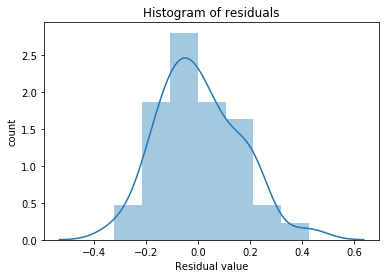

In [19]:
def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    
hist_resids(y_test, y_score)    

This histogram shows that the residuals are in a small range. However, there is some noticeable skew in the distribution. 

Next, execute the code in the cell below to display the Q-Q Normal plot. 

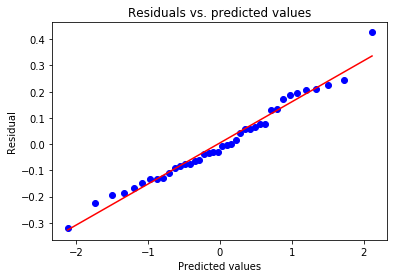

In [20]:
def resid_qq(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    ss.probplot(resids.flatten(), plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    
resid_qq(y_test, y_score)   

As with the histogram, the Q-Q Normal plot indicates the residuals are close to Normally distributed, show some skew (deviation from the stright line). This is particularly for large positive residuls. 

There is one more diagnostic plot. Execute the code in the cell below to dislplay the plot of residuals vs. predicted values. 

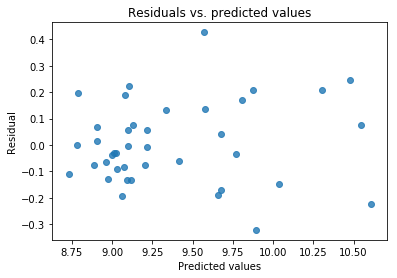

In [21]:
def resid_plot(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
 
resid_plot(y_test, y_score) 

This plot looks reasonable. The residual values appear to have a fairly constant dispursion as the predicted value changes. A few large residuals are noticable, particularly on the positive side.

But, wait! This residual plot is for the log of the auto price. What does the plot look like when transformed to real prices? Execute the code in the cell below to find out. 

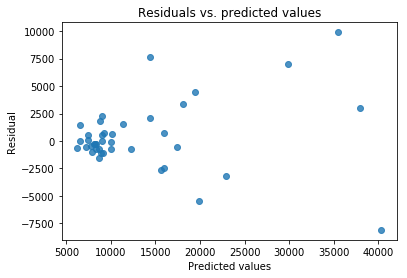

In [22]:
y_score_untransform = np.exp(y_score)
y_test_untransform = np.exp(y_test)
resid_plot(y_test_untransform, y_score_untransform) 

Notice that the untransformed residuals show a definite trend. The dispursion of the residuals has a cone-like pattern increasing to the right. The regression model seems to do a good job of predicting the price of low cost cars, but becomes progressively worse as the price of the car increases. 

## Summary

In this lesson you have done the following in the process of constructing and evaluating a multiple linear regression model:   
1. Transformed the label value to make it more symmetric and closer to a Normal distribution.
2. Aggregated categories of a categorical variable to improve the statistical representation. 
3. Scaled the numeric features. 
4. Recoded the categorical features as binary dummy variables. 
5. Fit the linear regression model using Scikit-learn. 
6. Evaluated the performance of the model using both numeric and graphical methods. 

It is clear from the outcome of the performance evaluation that this model needs to be improved. As it is, the model shows poor generalizatiion. 